In [2]:
!pip install chess

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [1]:
import chess.pgn
import numpy as np
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import copy

import pandas as pd
from matplotlib.pyplot import figure

In [4]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Data import

https://medium.com/analytics-vidhya/analyzing-chess-positions-with-python-26d73b7c892

In [58]:
lookup_fen = {
    'p': np.array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=bool),
    'n': np.array([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=bool),
    'b': np.array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=bool),
    'r': np.array([0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0], dtype=bool),
    'q': np.array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0], dtype=bool),
    'k': np.array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0], dtype=bool),
    'P': np.array([0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0], dtype=bool),
    'N': np.array([0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0], dtype=bool),
    'B': np.array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0], dtype=bool),
    'R': np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0], dtype=bool),
    'Q': np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0], dtype=bool),
    'K': np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1], dtype=bool),
}
# just reverse the dictionary and if a frame is all 12 zeros, set its item to none
lookup_hot = {tuple(value): key for key, value in lookup_fen.items()}
lookup_hot[tuple([False for _ in range(12)])] =  None

In [59]:
def piecetovec(piece):
    return lookup_fen.get(piece, None)

def vectopiece(vec):
    return lookup_hot[tuple(vec)]

def fentohot(fen):
    iter = 0
    onehotboard = np.zeros((64, 12), dtype=bool)
    for p in fen:
        if p == ' ':
            break
        if p == '/':
            continue
        encoding = piecetovec(p)
        if encoding is not None:
            onehotboard[iter, :] = encoding
            iter = iter + 1
        else:
            iter = iter + int(p)

    return onehotboard

def hottofen(onehot):
    jter = 0
    fenboard = ''
    for iter in range(64):
        if iter % 8 == 0 and iter > 0:
            if jter > 0:
                fenboard += str(jter)
                jter = 0

            fenboard += '/'

        key = vectopiece(hot[iter, :])

        if key is not None:
            if not jter == 0:
                fenboard += str(jter)
                jter = 0

            fenboard += key
        else:
            jter += 1

    if not jter == 0:
        fenboard += str(jter)
        jter = 0
    
    return fenboard

In [60]:
# encode game results
results_dict = {
    '1-0': 1,
    '0-1': 2,
    '1/2-1/2': 3
}

In [ ]:
pgn = open(f'drive/MyDrive/Chess/twic{jter}.pgn')

game = chess.pgn.rad_game

In [ ]:
positions = np.zeros((768, 100000), dtype=bool)
iter = 0

# keep track of elo of both players, and the game outcome
# also store FIDE player ID
elo_black = np.zeros(100000, dtype = np.short)
elo_white = np.zeros(100000, dtype = np.short)
FID_black = np.zeros(100000, dtype = np.short)
FID_white = np.zeros(100000, dtype = np.short)
# 1 for white win, 2 for black win, 3 for draw
game_outcome = np.zeros(100000, dtype = np.short)
desired_tags = ['BlackElo', 'WhiteElo', 'BlackFideId', 'WhiteFideId', "Result"]

# Pulled games off of https://theweekinchess.com/twic
# tournament chess games

for jter in range(1440, 1464):
    print(jter)
    pgn = open(f'drive/MyDrive/Chess/twic{jter}.pgn')
    
    while True:
        try:
            game = chess.pgn.read_game(pgn)
        except UnicodeDecodeError:
            print('Cannot decode game')
            continue
        
        if game is None:
            break

        board = game.board()
        contains_all = all([tag in game.headers.keys() for tag in desired_tags])
        # could check to make sure all headers are included here
        if contains_all:
          for move in game.mainline_moves():
              board.push(move)
              hot = fentohot(board.fen()).reshape((768,))
              positions[:,iter] = hot
              # store game information
              # check to see if all desired tags are there

              elo_black[iter] = int(game.headers['BlackElo'])
              elo_white[iter] = int(game.headers['WhiteElo'])
              FID_black[iter] = int(game.headers['BlackFideId'])
              FID_white[iter] = int(game.headers['WhiteFideId'])
              game_outcome[iter] = results_dict[game.headers['Result']]

              iter = iter + 1
              # if positions needs to be expanded, pad it
              if iter == positions.shape[1]:
                  # Double array size to get amortized O(1) additions
                  positions = np.pad(positions, ((0, 0),(0, iter)), 'constant', constant_values=(None, 0))
                  elo_black = np.pad(elo_black, (0, iter), 'constant', constant_values=0)
                  elo_white = np.pad(elo_white, (0, iter), 'constant', constant_values=0)
                  FID_black = np.pad(FID_black, (0,iter), 'constant', constant_values=0)
                  FID_white = np.pad(FID_white, (0,iter), 'constant', constant_values=0)
                  game_outcome = np.pad(game_outcome, (0,iter), 'constant', constant_values=0)

# ignore zeros afterwards
positions = positions[:, 0:iter]
elo_black = elo_black[0:iter]
elo_white = elo_white[0:iter]
FID_black = FID_black[0:iter]
FID_white = FID_black[0:iter]
game_outcome = game_outcome[0:iter]

In [9]:
# save one hot board positions to drive
np.save('drive/MyDrive/Chess/data/positions', positions)
np.save('drive/MyDrive/Chess/data/elo_black', elo_black)
np.save('drive/MyDrive/Chess/data/elo_white', elo_white)
np.save('drive/MyDrive/Chess/data/FID_black', FID_black)
np.save('drive/MyDrive/Chess/data/FID_white', FID_white)
np.save('drive/MyDrive/Chess/data/game_outcome', game_outcome)

# I don't think np save uses any compression, which would
# certainly be useful for these sparse vectors

In [10]:
iter

13123364

## Preliminary data analysis

In [63]:
# Download the data from the mounted drive
positions = np.load('drive/MyDrive/Chess/data/positions.npy')
elo_black = np.load('drive/MyDrive/Chess/data/elo_black.npy')
elo_white = np.load('drive/MyDrive/Chess/data/elo_white.npy')
FID_black = np.load('drive/MyDrive/Chess/data/FID_black.npy')
FID_white = np.load('drive/MyDrive/Chess/data/FID_white.npy')
game_outcome = np.load('drive/MyDrive/Chess/data/game_outcome.npy')

In [64]:
positions.shape

(768, 13123364)

In [ ]:
positions = np.transpose(positions)

In [69]:
FID_black.shape

(13123364,)

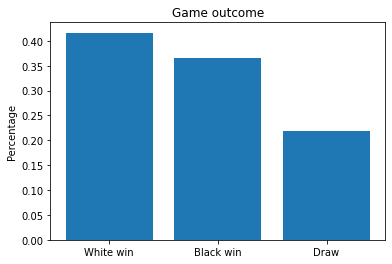

In [37]:
data = {'White win': np.mean(game_outcome == 1), 'Black win': np.mean(game_outcome == 2), 'Draw': np.mean(game_outcome == 3)}
names = list(data.keys())
values = list(data.values())
fig, axs = plt.subplots()
axs.bar(names, values)
plt.ylabel("Percentage")
plt.title("Game outcome")
fig.show()

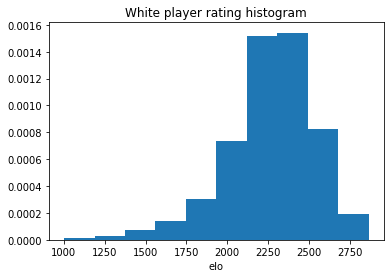

In [4]:
plt.hist(elo_white, density = True)
plt.title("White player rating histogram")
plt.xlabel("elo")
plt.show()

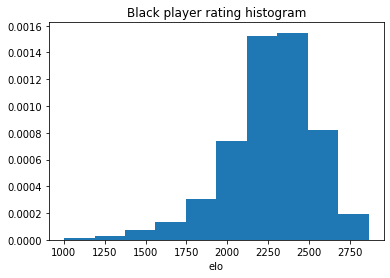

In [5]:
plt.hist(elo_black, density = True)
plt.title("Black player rating histogram")
plt.xlabel("elo")
plt.show()

In [38]:
!pip install sklearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for sklearn: filename=sklearn-0.0.post1-py3-none-any.whl size=2344 sha256=3a5ca37dab641436dfeb1baf83d3212b38427321f870df298befeee7df563a6d
  Stored in directory: /root/.cache/pip/wheels/42/56/cc/4a8bf86613aafd5b7f1b310477667c1fca5c51c3ae4124a003
Successfully built sklearn


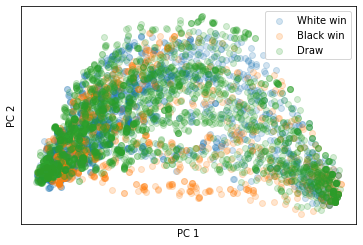

In [57]:
# naive try at embedding chess games using PCA

import numpy as np
from sklearn.decomposition import PCA

pca = PCA(n_components = 2)
n_points = 6000
positions_small = np.transpose(positions[:,0:0+n_points])
pca.fit(positions_small)
n_points_visualize = 2000
ps = pca.fit_transform(positions_small)
plt.scatter(ps[:,0][game_outcome[0:n_points] == 1], ps[:,1][game_outcome[0:n_points] == 1], label = 'White win', alpha = .2)
plt.scatter(ps[:,0][game_outcome[0:n_points] == 2], ps[:,1][game_outcome[0:n_points] == 2], label = 'Black win', alpha = .2)
plt.scatter(ps[:,0][game_outcome[0:n_points] == 3], ps[:,1][game_outcome[0:n_points] == 3], label = 'Draw', alpha = .2)
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.xticks([]); plt.yticks([])
plt.legend()
plt.show()


## TODO

Geometry regularized autoencoder

1.   Reconstruction loss alone
2.   Contrastive loss where we use the game outcome as the label
3.   Loss penalty based on the strength of the players
4.   Any combinations of the above
5.   Look at the size of the embedding layer. i.e. have a 10 dimensional embedding and then use PHATE to project it down into 2 dimension for visualization

b_0, b_1, b_2, b_3, ... b_n

f(b_0), f(b_1), ... maps out some trajectory in latent space

also could ask questions about the curvature of these points in embedding space
also see if we can see if a move is good


## Feature engineering

In [6]:
positions.shape
# eventually do we want to try and make this into something 
# that's 8 x 8 x 12 and treat it as a 12 channel image?

(768, 13123364)

In [27]:
flat_prob = np.mean(positions, (1,))
flat_sum = np.sum(positions, (1,))
positionprob = np.mean(positions, (1,)).reshape(64,12)

In [29]:
piece_lookup = {'p': 0, 'n': 1, 'b': 2, 'r': 3, 'q': 4, 'k': 5, 'P': 6, 'N': 7, 'B': 8, 'R': 9, 'Q': 10, 'K': 11}
file_lookup = {'a': 7, 'b': 6, 'c': 5, 'd': 4, 'e': 3, 'f': 2, 'g': 1, 'h': 0}
# this file lookup is very unintuitive... but oh well


def index_of(piece, file, rank):
    board_offset = rank*8 + file_lookup[file]
    piece_offset = piece_lookup[piece]
    return (64-board_offset)*12 - (12 - piece_offset)

In [30]:
piece = ['p', 'n', 'b', 'r', 'q', 'k', 'P', 'N', 'B', 'R', 'Q', 'K']*8*8
file = [r for _ in range(8) for r in 'abcdefgh' for _ in range(12) ]
rank = [f for f in range(8) for _ in range(12) for _ in range(8) ]

index = [index_of(p, f, r) for (p, f, r) in zip(piece, file, rank)]
probability = [flat_prob[ind] for ind in index]
count = [flat_sum[ind] for ind in index]

df = pd.DataFrame.from_dict({
    'piece': piece,
    'file': file,
    'rank': [r+1 for r in rank],
    'index': index,
    'probability': probability,
    'count': count})

In [31]:
pd.set_option('display.max_rows', 768)
df = df.sort_values(by='probability')
# to save the positions
# df.to_csv('./positions.csv')

Text(0.5, 1.0, 'Histogram of Piece-Position Probabilities')

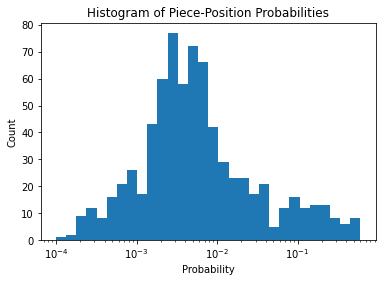

In [32]:
x = positionprob.flatten()
hist, bins = np.histogram(x, bins=30)
logbins = np.logspace(np.log10(1e-4), np.log10(.60), len(bins))
plt.hist(x, bins=logbins)
plt.xscale('log')
plt.xlabel('Probability')
plt.ylabel('Count')
plt.title('Histogram of Piece-Position Probabilities')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


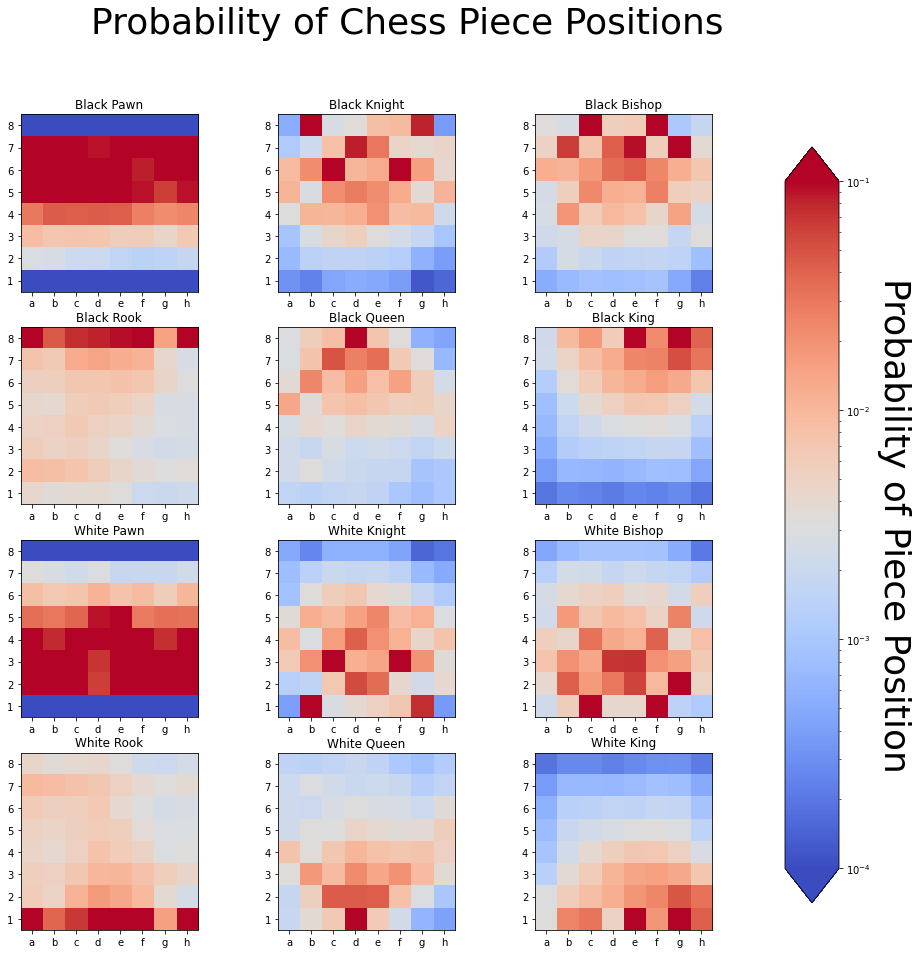

In [33]:
title_lookup = {'p': 'Pawn', 'n': 'Knight', 'b': 'Bishop', 'r': 'Rook', 'q': 'Queen', 'k': 'King'}


file_tick = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h']
rank_tick = range(8,0,-1)

norm = colors.LogNorm(vmin=1e-4, vmax=1e-1) 
cmap = copy.copy(matplotlib.cm.get_cmap('coolwarm'))
cmap.set_bad(cmap(0))

fig, ax = plt.subplots(4,3)
fig.set_figheight(15)
fig.set_figwidth(15)

iter = 0
for key in piece_lookup:
    this_ax = ax[np.unravel_index(iter, (4,3))]
    iter = iter+1
    
    color = 'Black' if (key.islower()) else 'White'
    
    title = color + ' ' + title_lookup[key.lower()]
    
    to_show = positionprob[:,piece_lookup[key]].reshape(8,8)

    im = this_ax.imshow(to_show, cmap=cmap, norm=norm)
    this_ax.set_xticks(np.arange(len(file_tick)))
    this_ax.set_yticks(np.arange(len(rank_tick)))
    this_ax.set_xticklabels(file_tick)
    this_ax.set_yticklabels(rank_tick)
    
    this_ax.set_title(title)

    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])

cbar = fig.colorbar(im, cax=cbar_ax, extend='both')
cbar.set_label('Probability of Piece Position', rotation=270, fontsize=36, labelpad=40)
cbar.minorticks_on()

fig.suptitle('Probability of Chess Piece Positions', fontsize=36)
plt.savefig('drive/MyDrive/Chess/chess_piece_position.jpg')
plt.show()


## Autoencoder
 

In [ ]:
import torch 
from torch.utils.data import DataLoader

